In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import marketsimcode as m

In [2]:
def symbol_to_path(symbol, base_dir=None): 
    return ("C:\\Users\\aaladdha\\Desktop\\Masters\\ML4T_2021Spring\\data\\{}.csv".format(str(symbol)))  
 

def get_data(symbols,dates, addSPY = True, colname = 'Adj Close'):
    df = pd.DataFrame(index = dates)
    if addSPY and "SPY" not in symbols:
        symbols =['SPY'] + list(symbols)
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col="Date", parse_dates=True, usecols=["Date", colname],na_values=["nan"])
        df_temp = df_temp.rename(columns={colname: symbol})
        df = df.join(df_temp)
        if symbol == "SPY": 
            df = df.dropna(subset=["SPY"])
        
    return df    

In [3]:
def getprices(symbol, start_date, end_date):
    prices = get_data([symbol], pd.date_range(start_date, end_date))
    if 'SPY' not in symbol:
            prices.drop('SPY', axis = 1, inplace = True)
         
    prices= prices.fillna(method ='ffill')
    prices = prices.fillna(method = 'bfill')
    prices_normed = prices/prices.iloc[0]
    return prices_normed 

In [4]:
def Portfolio_Statistics(portvals):
    daily_returns = portvals.copy()
    daily_returns[1:] = (portvals[1:] / portvals[:-1].values) - 1
    daily_returns = daily_returns[1:]

    cum_ret = (portvals.iloc[-1] / portvals.iloc[0]) - 1
    avg_daily_ret = daily_returns.mean()
    std_daily_ret = daily_returns.std()
    sharpe_ratio = np.sqrt(252.0) * (avg_daily_ret / std_daily_ret)

    return cum_ret,avg_daily_ret,std_daily_ret,sharpe_ratio


In [13]:
def benchmark(symbol, sd, ed, shares):  

    prices =  getprices(symbol, sd, ed)
    df_trades = pd.DataFrame(index = prices.index)
    df_trades[symbol] = 0

    start =df_trades.index.min()
    end = df_trades.index.max()
    df_trades.loc[start,symbol] = shares
    return df_trades


In [6]:
def compute_portvals(trade_df, start_val=100000,  commission=0.0,impact=0.0):    
    
    orders = trade_df
    orders.sort_index(inplace=True)
    start_date = orders.index.min()
    end_date = orders.index.max()
    stocks = list(trade_df.columns)

   #Getting Stock Prices for the range start_date - end_date
    prices = get_data(stocks, pd.date_range(start_date, end_date))
    prices.ffill(inplace=True)    #Forward Filling first
    prices.bfill(inplace=True)    #Backward filling

    #SPY gets automatically added using get_data. So, delete SPY if not in the list of orders
    if 'SPY' not in stocks:
        prices.drop('SPY', axis=1, inplace=True)

    prices['Cash'] = 1   #Adding a cash field to prices and initializing to 1 so that we can multiply it straight away with holdings

    trade = pd.DataFrame(np.zeros(prices.shape), columns=prices.columns, index=prices.index)
    trade.iloc[0, -1] = start_val  #Cash for first date set to start value
    
    for sym in stocks:

        for index, row in orders.iterrows():

            stock = sym
            shares = row[sym]
            stock_price = prices.loc[index, stock]  # getting stock price from prices df

            if shares < 0:
                trade.loc[index, stock] = trade.loc[index, stock] + shares
                stock_price = stock_price - (stock_price * impact)

            else:
                trade.loc[index, stock] = trade.loc[index, stock] + shares
                stock_price = stock_price + (stock_price * impact)

            # accounting market impact
            trade.loc[index, 'Cash'] = trade.loc[index, 'Cash'] - commission - (stock_price * shares)

        holding = trade.cumsum()
        holding_value = holding * prices  # computing stock total values
        portvals = holding_value.sum(axis=1)

    return portvals


In [7]:
def testPolicy(symbol = "JPM",sd=dt.datetime(2010, 1, 1), ed=dt.datetime(2011,12,31), sv = 100000):

    prices =  getprices(symbol, sd, ed)
    prices_temp = prices.copy()
   
    #Looking 1 day ahead 
    prices_temp['NextDay'] = prices_temp.shift(-1)
    trade_fwd = pd.DataFrame(index = prices.index)
    trade_bwd = pd.DataFrame(index = prices.index)

    #computing trades by looking at prices 1 day ahead 
    trade_fwd['Order'] = np.where(prices_temp[symbol] < prices_temp['NextDay'], 'BUY', 'SELL')

    #Now looking at orders 1 day before and checking whether we opted for a Buy or Sell opp. If buy yesterday, then sell today and vice versa
    trade_bwd = trade_fwd.copy()
    trade_bwd['Order'] = trade_bwd.shift(1)

    trade_bwd = trade_bwd[1:]   #cant look prior to the first day 
    trade_bwd['Orders_Temp'] = np.where(trade_bwd['Order'] == 'BUY', 'SELL','BUY')
    trade_bwd.drop(['Order'], axis =1, inplace = True)
    trade_bwd.columns = ['Order']

    trade_df = pd.concat([trade_fwd, trade_bwd])
    trade_df.sort_index(inplace = True, ascending = True)
    trade_df['Shares'] = np.where(trade_df['Order'] =='BUY', 1000, -1000)
    trade_df['Symbol'] = symbol
    trade_df = trade_df.loc[:,['Shares']]
    trade_df.columns = [symbol]

    
    return trade_df




In [8]:
def test_code():
    sd=dt.datetime(2008,1,1)
    ed=dt.datetime(2009,12,31)
    symbol = "JPM"
    
    #Theoretically Optimal Strategy
    df_trades_optimal = testPolicy(symbol = "JPM", sd=sd, ed=ed, sv = 100000)
    port_vals_optimal = compute_portvals(df_trades_optimal, start_val = 100000, commission = 0, impact = 0)
    
    #Normalizing PortFolio Values
    port_vals_norm_optimal = port_vals_optimal/port_vals_optimal.iloc[0]

    cum_ret_opt,avg_daily_ret_opt,std_daily_ret_opt,sharpe_ratio_opt = Portfolio_Statistics(port_vals_norm_optimal)
    
    print(f"Date Range: {sd} to {ed} for {symbol}")
    print()
    print("Optimal Strategy")
    print(f"Sharpe Ratio of Fund: {sharpe_ratio_opt}")  
    print(f"Cumulative Return of Fund: {cum_ret_opt}") 
    print(f"Standard Deviation of Fund: {std_daily_ret_opt}")
    print(f"Average Daily Return of Fund: {avg_daily_ret_opt}") 
    print(f"Final Portfolio Value: {port_vals_optimal[-1]}")
    
    #Benchmark Strategy 
    df_trades_benchmark = benchmark(symbol = "JPM", sd=sd, ed=ed,shares = 1000)
    port_vals_benchmark = compute_portvals(df_trades_benchmark, start_val = 100000, commission = 0, impact = 0)
    
    #Normalizing PortFolio Values
    port_vals_norm_benchmark = port_vals_benchmark/port_vals_benchmark.iloc[0]

    cum_ret_bench,avg_daily_ret_bench,std_daily_ret_bench,sharpe_ratio_bench = Portfolio_Statistics(port_vals_norm_benchmark)
    print()
    print("Benchmark Strategy")

    print(f"Sharpe Ratio of Fund: {sharpe_ratio_bench}")  
    print(f"Cumulative Return of Fund: {cum_ret_bench}") 
    print(f"Standard Deviation of Fund: {std_daily_ret_bench}")
    print(f"Average Daily Return of Fund: {avg_daily_ret_bench}") 
    print(f"Final Portfolio Value: {port_vals_benchmark[-1]}")
    
  
    plt.figure(figsize=(15,7))
    plt.plot(port_vals_norm_optimal, 'red')
    plt.plot(port_vals_norm_benchmark,'green')
    plt.title("Portfolio vs Benchmark")
    plt.show()


Date Range: 2008-01-01 00:00:00 to 2009-12-31 00:00:00 for JPM

Optimal Strategy
Sharpe Ratio of Fund: 13.322769848217233
Cumulative Return of Fund: 5.7861
Standard Deviation of Fund: 0.004547823197907996
Average Daily Return of Fund: 0.0038167861508578214
Final Portfolio Value: 678610.0

Benchmark Strategy
Sharpe Ratio of Fund: 0.1569184064240322
Cumulative Return of Fund: 0.012299999999999978
Standard Deviation of Fund: 0.01700436627121376
Average Daily Return of Fund: 0.00016808697819094233
Final Portfolio Value: 101230.0


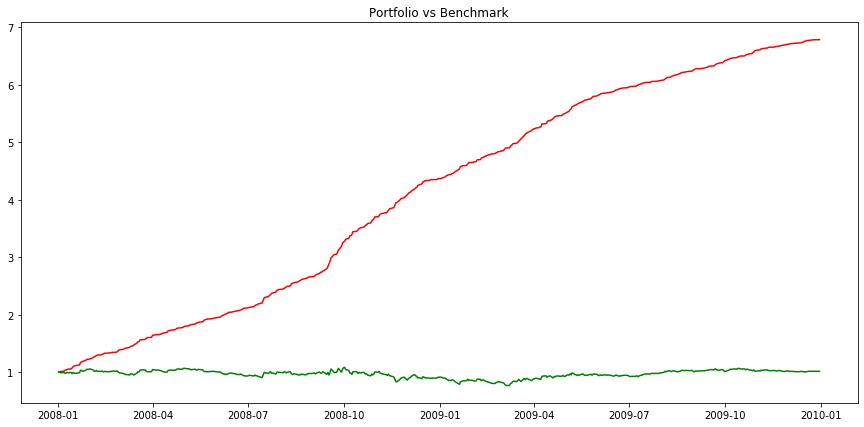

In [14]:
if __name__ == "__main__":
    test_code()

In [10]:
plt.figure(figsize=(20,7))
plt.plot(port_vals_norm_optimal, 'm-')
plt.plot(port_vals_norm_benchmark,'dodgerblue')
plt.title("Portfolio vs Benchmark")
plt.text(plt.xlim()[0] + 15, 
               plt.ylim()[0] + 4 ,'AARTI LADDHA',  alpha=0.5,fontsize=90, color='gray',va='center')
plt.show()
plt.savefig('test.png')

NameError: name 'port_vals_norm_optimal' is not defined

<Figure size 1440x504 with 0 Axes>